In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
plt.rcParams.update({'font.size': 14})

from common_pyfuncs import *

sol_filename = "../build/sol.csv"
SDsol_filename = "../build/solSD.csv"
setup_filename = "../build/sol_setup.txt"

#savedir = "./ipynbplots/"

In [14]:
### read in constants and intial setup from .hpp or .txt files
#CONSTS, notfloats = read_cpp_into_floats("./constants.hpp")
#INIT, notfloats2 = read_cpp_into_floats("./init.hpp") 
CONSTS, notfloats = read_cpp_into_floats(setup_filename)
INITS = {
  "iW"      : CONSTS["iW"],
  "DROPVOL"    : CONSTS["DROPVOL"],
  "nsupers" : int(CONSTS["NSUPERS"]),
}
MCONSTS = {
  "RGAS_DRY"   : CONSTS["RGAS_UNIV"]/CONSTS["MR_DRY"],
  "RGAS_V"     : CONSTS["RGAS_UNIV"]/CONSTS["MR_WATER"],
  "CP0"        : CONSTS["CP_DRY"],
  "MR0"        : CONSTS["MR_DRY"],
  "Mr_ratio"   : CONSTS["MR_WATER"]/CONSTS["MR_DRY"],
}
MCONSTS["RHO0"]       = CONSTS["P0"]/(MCONSTS["RGAS_DRY"]*CONSTS["TEMP0"])

print("---- Additional Constants Derived -----")
for c in MCONSTS:
  print(c, "=", MCONSTS[c])
nsupers    = int(INITS["nsupers"])                  
VOL = INITS["DROPVOL"]                                # parcel volume [m]                    
print("---------------------------------------------")


---- Constants read from  ../build/sol_setup.txt -----
TEMP_INIT = 273.15
P_INIT = 100000.0
relh_init = 60.0
qc_init = 0.0
SUPERS = 8192.0
NSUPERS = 10.0
DROPVOL = 1000000.0
COND_TSTEP = 5e-05
COLL_TSTEP = 1.0
nout = 100.0
iW = 0.5
rtol = 1e-06
G = 9.80665
RGAS_UNIV = 8.314462618
MR_WATER = 0.01801528
MR_DRY = 0.0289647
LATENT_V = 2437300.0
CP_DRY = 1004.9
CP_V = 1864.0
C_L = 4180.0
RHO_DRY = 1.177
RHO_L = 1000.0
le = 1000000.0
RHO_SOL = 2200.0
MR_SOL = 0.058443
IONIC = 2.0
W0 = 0.5
TIME0 = 4000.0
P0 = 100000.0
TEMP0 = 273.15
R0 = 1e-06
---------------------------------------------
---- Not floats read from  ../build/sol_setup.txt -----
iRho_l = dlc::Rho_l
iRho_sol = dlc::Rho_sol
iMr_sol = dlc::Mr_sol
iIONIC = dlc::IONIC
TSPAN[2] = {0, 4000}
atols[4] = {1e-6, 1e-6, 1e-6, 1e-6}
RGAS_DRY = RGAS_UNIV / MR_DRY
RGAS_V = RGAS_UNIV / MR_WATER
DYNVISC = 18.45 * 1e-6
LATENT_RGAS_V = LATENT_V / RGAS_V
RHO0 = P0 / (DC::RGAS_DRY * TEMP0)
CP0 = DC::CP_DRY
MR0 = DC::MR_DRY
F0 = TIME0 / (RHO0 * R0 * 

In [15]:
### Helper Functions 
def saturation_pressure(T):
  ''' Calculate the equilibrium vapor pressure 
  of water over liquid water ie. the
  saturation pressure (psat [Pa]). Equation taken from
  typhon.physics.thermodynamics.e_eq_water_mk.'''
  
  if np.any(T <= 0):
      err = 'T must be larger than 0K.'
      raise ValueError(err)

  lnpsat = (54.842763                    # ln(psat) [Pa]
        - 6763.22 / T
        - 4.21 * np.log(T)
        + 0.000367 * T
        + np.tanh(0.0415 * (T - 218.8))
        * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))

  return np.exp(lnpsat)               # psat [Pa]



def dry_pot_temp(Temp, P, qv):
    ''' calculate potential Temperature [K]
    assuming moist (unsaturated) air with
    vapour content qv '''
   
    Cpdry = CONSTS["CP_DRY"]
    Cpv = CONSTS["CP_V"]
    Rgasdry = MCONSTS["RGAS_DRY"]
    Rgasv = MCONSTS["RGAS_V"]

    Cp =  Cpdry * (1+qv*Cpv/Cpdry)/(1+qv)
    Rgas = Rgasdry *(1+qv*Rgasv/Rgasdry)/(1+qv)
    
    Theta = Temp*(P[0]/P)**(Rgas/Cp)
    
    return Theta




def golovin_sol(rspan, t, nbins, b, n_a, r_a,
        ax=False, lab=None, c='k', l='--'):
        
        if t == 0: 
            t=1e-10

        hedgs = np.linspace(np.log(rspan[0]), np.log(rspan[1]), nbins+1)             # edges to lnr bins
        hcens = (hedgs[1:]+hedgs[:-1])/2                                             # lnr bin centres
        #hwdths = hedgs[1:]- hedgs[:-1]                                              # lnr bin widths
        #rwdths = np.exp(hedgs)
        r = np.exp(hcens)
        
        vol_a = 4/3*np.pi*r_a**3
        x = 4/3*np.pi*r**3/vol_a
        tau = 1-np.exp(-b*n_a*vol_a*t)
        bsl_exp = iv(1, 2*x*np.sqrt(tau))*np.exp(-(1+tau)*x)
        asym = 1/(2*np.sqrt(np.pi*x))*np.exp(x*(2*np.sqrt(tau)-1-tau))
        np.nan_to_num(bsl_exp, copy=False, nan=asym, posinf=asym, neginf=np.inf)

        phi = (1-tau)/(x*np.sqrt(tau))*bsl_exp
        n = n_a/vol_a*phi
        #dv_dlnR = 4/3*np.pi*((rwdths[1:])**3-(rwdths[:-1])**3)/hwdths
        dv_dlnR = 3*(4/3*np.pi*r**3)
        massdens = n*CONSTS["RHO_L"]*(4/3*np.pi*r**3)*dv_dlnR       #mass density as if water [Kg m^-3 /unit lnR]]

        if ax:
            ax.plot(np.log(r), massdens*1000, label=lab, color=c, linestyle=l)

        return massdens*1000, hcens



### Plotting functions
def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    if type(c)==type(0):
        c= 'C'+str(c)
    ax.plot(x,y, label=lab, color=c, linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)



In [16]:
#### Get data and Re-Dimensionalise Solution ###
t, p, temp, qv, qc = get_soldata(sol_filename, CONSTS["TIME0"], CONSTS["P0"], CONSTS["TEMP0"]) 
eps, r, m_sol = get_SDdata(SDsol_filename, nsupers, CONSTS["R0"], MCONSTS["RHO0"]) 
w = INITS["iW"]
z = t*w
SDprops = CommonSuperdropProperties(nsupers, VOL, CONSTS["RHO_L"], CONSTS["RHO_SOL"], 
                CONSTS["MR_SOL"], CONSTS["IONIC"])


### Some derived quantities
# theta = dry_pot_temp(temp, p, qv)                      # parcel potential temp
# gamma = (MCONSTS["RGAS_DRY"]/CONSTS["CP_DRY"]) 
# dry_adia = temp[0]*(p/p[0])**gamma            # dry adiabatic temp
# dry_adia_theta = dry_adia*(p[0]/p)**gamma    # dry adiabatic theta (=const)

# pv = qv*p/(MCONSTS["Mr_ratio"] + qv) 
# psat = saturation_pressure(temp)
# relh = pv/psat
# qsat = MCONSTS["Mr_ratio"] * psat/(p-pv) 
# s = qv/qsat - 1   


--- Raw Data Shapes ---
variables: t, p, temp, qv, qc
(101,) (101,) (101,) (101,) (101,)
--- Non Dimensional Max/Mins of Data ---
time: 5.2212489334e-314 1.000000000015721
p: 0.7743109344468574 1.0
temp: 0.9361562295247172 1.0
(qv, qc) (0.0015207734393043399, 0.0) (0.002289344792393188, 0.0007685713530888478) 

--- Raw SD Data Shapes ---
variables: eps, r, m_sol
(101, 10) (101, 10) (101, 10)
--- Non Dimensional Max/Mins of Data ---
droplet eps: 5940761135.0 469144719688.0
droplet r: 0.01412537544623 16.902419897861634
droplet m_sol: 0.02036468258612 2563761.641079235 

---- Superdrop Properties -----
nsupers = 10
parcel volume = 1000000.0 m^3
RHO_L = 1000.0 Kg/m^3
RHO_SOL = 2200.0 Kg/m^3
MR_SOL = 0.058443 Kg/mol
IONIC = 2.0
-------------------------------


individual superdroplet evolutions:


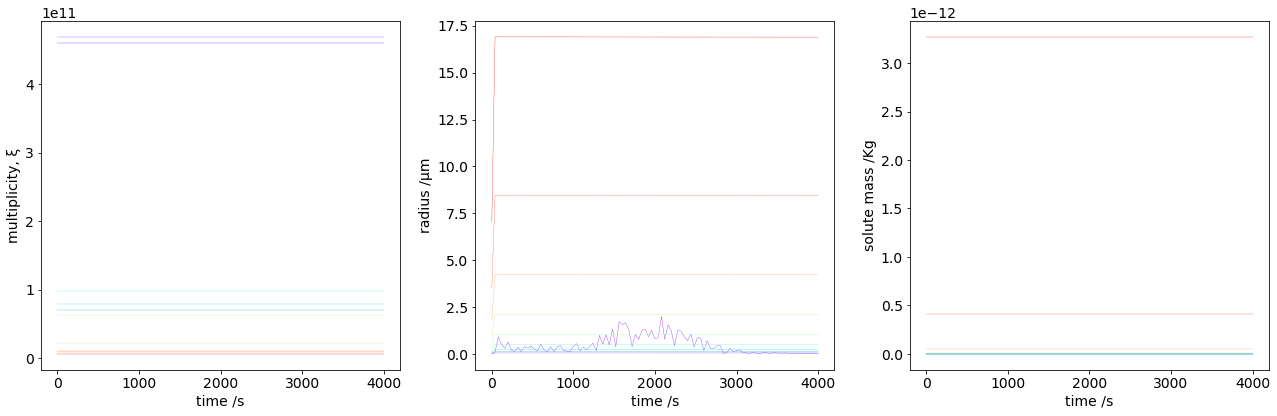

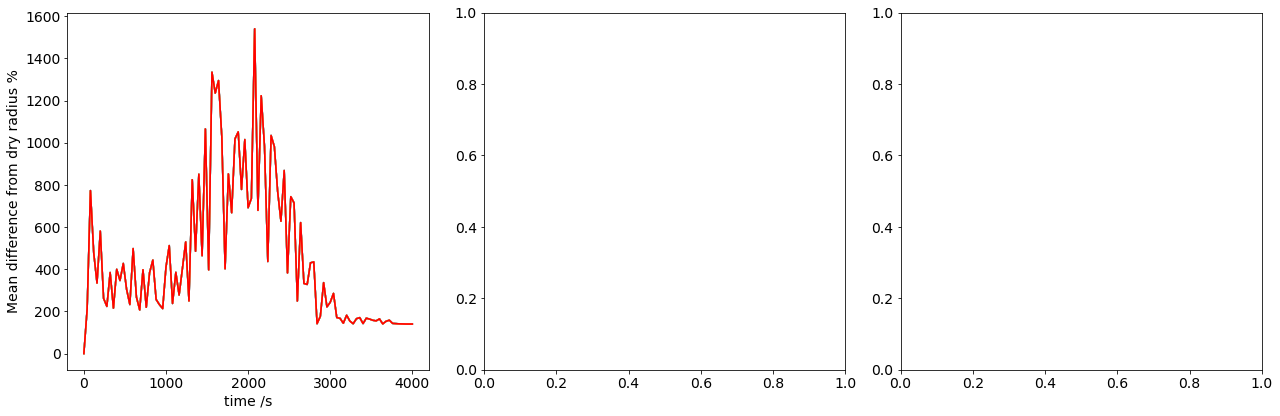

In [17]:
print("individual superdroplet evolutions:")
n = 10
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
colors=plt.cm.rainbow(np.linspace(0,1,n))
for i,c in zip(range(n), colors):
  axplt(axs[0], t, eps[:,i], xlab="time /s", ylab="multiplicity, \u03BE", c=c)
  axplt(axs[1], t, r[:,i]*1e6, xlab="time /s", ylab="radius /\u03BCm", c=c)
  axplt(axs[2], t, m_sol[:,i], xlab="time /s", ylab="solute mass /Kg",c=c)

for ax in axs:
  for line in ax.get_lines():
      line.set_linewidth(0.3)
plt.tight_layout()


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
dry_r = (3*m_sol/(4*np.pi*SDprops.RHO_SOL))**(1/3)
fracdiff = np.mean((r-dry_r)/dry_r, axis=1)
for i,c in zip(range(n), colors):
  axplt(axs[0], t, fracdiff*100, xlab="time /s", ylab="Mean difference from dry radius %", c=c)
plt.tight_layout()


total mass density as if water at t[0] =  1.1048378884799547e-05 g m$^{-3}$
total mass density as if water at t[-1] =  0.00015009188149570576 g m$^{-3}$
total solute mass density at t[0] =  2.4306433546559023e-05 g m$^{-3}$
total solute mass density at t[-1] =  2.4306433546559023e-05 g m$^{-3}$


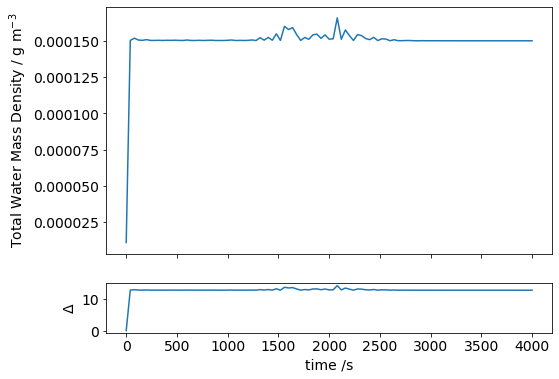

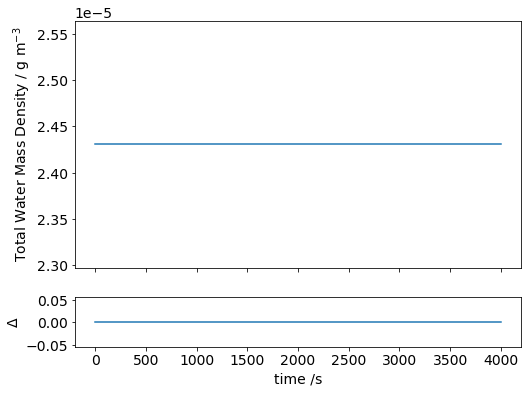

In [18]:
totmassdens = np.sum(eps*SDprops.m(r, 0)/VOL, axis=1)
print("total mass density as if water at t[0] = ", totmassdens[0]*1000, "g m$^{-3}$")
print("total mass density as if water at t[-1] = ", totmassdens[-1]*1000, "g m$^{-3}$")
gd = dict(height_ratios=[5,1])
fig, axs = plt.subplots(ncols=1, nrows=2, 
            figsize=(8,6), gridspec_kw=gd, sharex=True)
axplt(axs[0], t, totmassdens*1000, ylab="Total Water Mass Density / g m$^{-3}$")
axplt(axs[1], t, (totmassdens-totmassdens[0])/totmassdens[0], xlab="time /s", ylab="\u0394")


totmsoldens = np.sum(eps*m_sol/VOL, axis=1)
print("total solute mass density at t[0] = ", totmsoldens[0]*1000, "g m$^{-3}$")
print("total solute mass density at t[-1] = ", totmsoldens[-1]*1000, "g m$^{-3}$")
gd = dict(height_ratios=[5,1])
fig, axs = plt.subplots(ncols=1, nrows=2, 
            figsize=(8,6), gridspec_kw=gd, sharex=True)
axplt(axs[0], t, totmsoldens*1000, ylab="Total Water Mass Density / g m$^{-3}$")
axplt(axs[1], t, (totmsoldens-totmsoldens[0])/totmsoldens[0], xlab="time /s", ylab="\u0394")

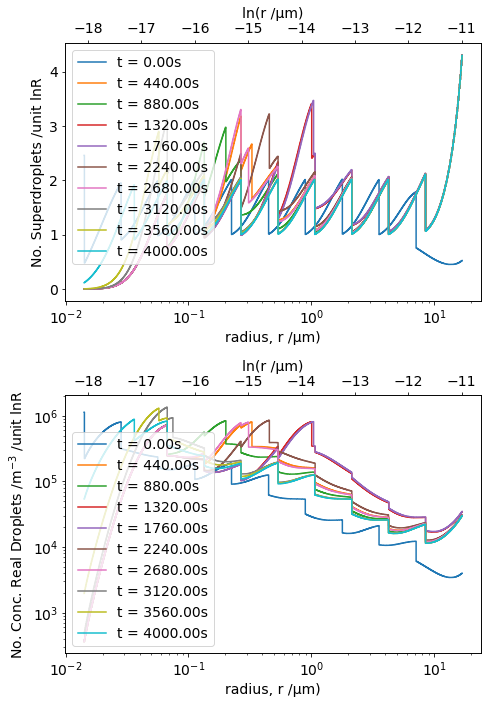

In [19]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
#rspan = [0.62e-6, 6.34e-2]
nplts = 10
tplt = np.linspace(t[0], t[-1], 10)
#tplt = [0, 1200, 2400, 3600]
#nplts = len(tplt)
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False


### No. distributions of SD and real droplets
ax1b = linear_twinax(ax1, np.log(r[0,:]), [1]*nsupers)
ax2b = linear_twinax(ax2, np.log(r[0,:]), eps[0,:]/VOL)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)

        logr_distribution(rspan, nbins, r[ind,:], [1]*nsupers, 
                ax=ax1, step=True, lab=tlab, c=c, ylab="No. Superdroplets /unit lnR",
                perlnR=True, smooth=smoothsig)

        logr_distribution(rspan, nbins, r[ind,:], eps[ind,:]/VOL, ax=ax2, 
                step=True, lab=tlab, c=c, ylab="No. Conc. Real Droplets /m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)

xlims = [np.exp(l)*1e6 for l in ax1.get_xlim()]
ax1b.set_xlim(xlims)
xlims = [np.exp(l)*1e6 for l in ax2.get_xlim()]
ax2b.set_xlim(xlims)

#ax1.set_yscale('log')
ax2.set_yscale('log')
plt.tight_layout()



t=0.00s, sum m_sol= 2.4306433546559023e-05 g/m^3, (as if water: 1.1048378884799555e-05 g/m^3)
t=1200.00s, sum m_sol= 2.4306433546559023e-05 g/m^3, (as if water: 1.1048378884799555e-05 g/m^3)
t=2400.00s, sum m_sol= 2.4306433546559023e-05 g/m^3, (as if water: 1.1048378884799555e-05 g/m^3)
t=3600.00s, sum m_sol= 2.4306433546559023e-05 g/m^3, (as if water: 1.1048378884799555e-05 g/m^3)


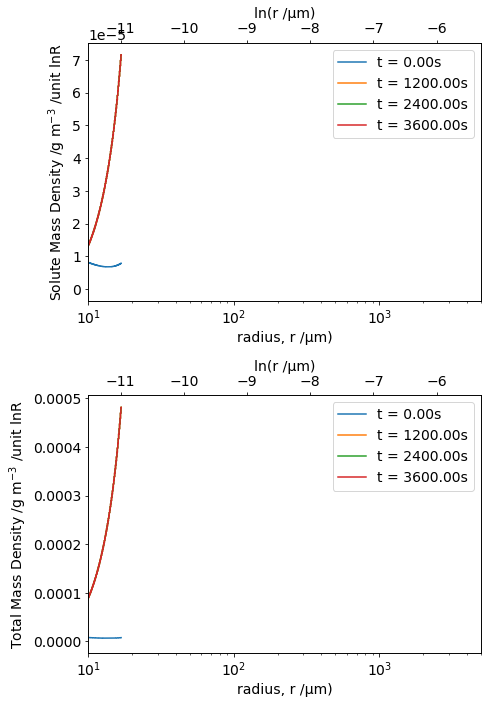

In [20]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
tplt = [0, 1200, 2400, 3600]
nplts = len(tplt)
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False

wghts1 = eps[0,:]*m_sol[0,:]/VOL*1000
wghts2 = eps[0,:]*SDprops.m(r[0,:], m_sol[0,:])/VOL*1000
ax1b = linear_twinax(ax1, np.log(r[0,:]), wghts1)
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts2)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        
        wghts1 = eps[ind,:]*m_sol[ind,:]/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts1, ax=ax1, 
                step=True, lab=tlab, c=c, 
                ylab="Solute Mass Density /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)

        wghts2 = eps[ind,:]*SDprops.m(r[ind,:], m_sol[ind,:])/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts2, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="Total Mass Density /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)
        
        sum1 = np.sum(eps[ind,:]*m_sol[ind,:]/VOL*1000)
        sum2 = sum1*SDprops.RHO_L/SDprops.RHO_SOL
        print("t={:.2f}s,".format(t[ind]), "sum m_sol=", sum1, "g/m^3, (as if water:", sum2, "g/m^3)")

# xlims = [np.exp(l)*1e6 for l in ax1.get_xlim()]
# ax1b.set_xlim(xlims)
# xlims = [np.exp(l)*1e6 for l in ax2.get_xlim()]
# ax2b.set_xlim(xlims)

xlims = [10, 5000]
ax1.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
ax2.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
ax1b.set_xlim(xlims)
ax2b.set_xlim(xlims)
plt.tight_layout()




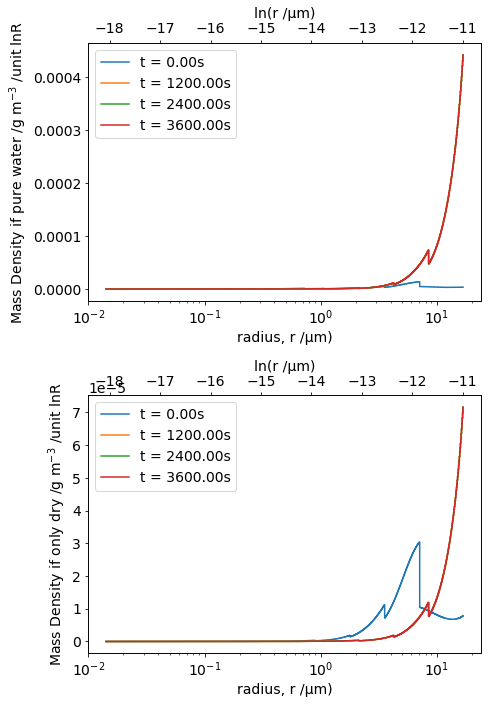

In [21]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
tplt = [0, 1200, 2400, 3600]
nplts = len(tplt)
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = False

wghts1 = eps[0,:]*SDprops.m(r[0,:], 0)/VOL*1000
dry_r0 = (3*m_sol[0,:]/(4*np.pi*SDprops.RHO_SOL))**(1/3)
wghts2 = eps[0,:]*SDprops.m(dry_r0, m_sol[0,:])/VOL*1000
ax1b = linear_twinax(ax1, np.log(r[0,:]), wghts1)
ax2b = linear_twinax(ax2, np.log(r[0,:]), wghts2)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        
        wghts1 = eps[ind,:]*SDprops.m(r[ind,:], 0)/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts1, ax=ax1, 
                step=True, lab=tlab, c=c, 
                ylab="Mass Density if pure water /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)


        dry_r = (3*m_sol[ind,:]/(4*np.pi*SDprops.RHO_SOL))**(1/3)
        wghts2 = eps[ind,:]*SDprops.m(dry_r, m_sol[ind,:])/VOL*1000
        logr_distribution(rspan, nbins, r[ind,:], wghts2, ax=ax2, 
                step=True, lab=tlab, c=c, 
                ylab="Mass Density if only dry /g m$^{-3}$ /unit lnR",
                perlnR=True, smooth=smoothsig)
        
xlims = [np.exp(l)*1e6 for l in ax1.get_xlim()]
ax1b.set_xlim(xlims)
xlims = [np.exp(l)*1e6 for l in ax2.get_xlim()]
ax2b.set_xlim(xlims)

# xlims = [10, 5000]
# ax1.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
# ax2.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
# ax1b.set_xlim(xlims)
# ax2b.set_xlim(xlims)
plt.tight_layout()





0.3911935535777198 0.12619146889603866


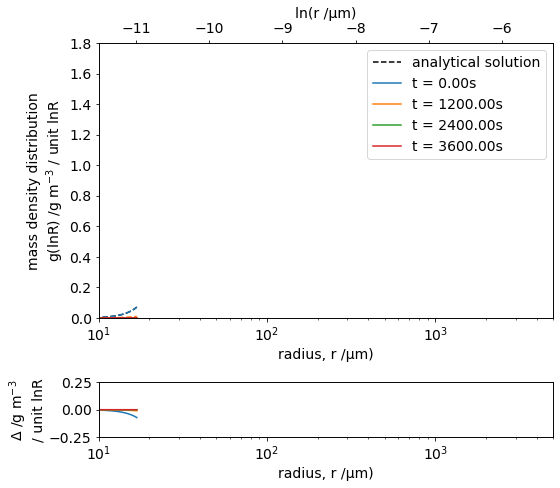

In [22]:
gd = dict(height_ratios=[5,1])
fig, [ax, ax_err] = plt.subplots(ncols=1, nrows=2, 
            figsize=(8,7), gridspec_kw=gd)
nbins = 1000
rspan = [np.amin(r), np.amax(r)]
tplt = [0, 1200, 2400, 3600]
nplts = len(tplt)
smoothsig = 0.62*nsupers**(-1/5)
#smoothsig = 0.2*nsupers**(-1/5)

print(smoothsig, smoothsig/0.62*0.2)

### no. conc distribution and mass density distribution 
### assuming all mass is water (m_sol=0)
for i in range(nplts):
        ind = np.argmin(abs(t-tplt[i]))
        tlab = 't = {:.2f}s'.format(t[ind])
        c = 'C'+str(i)
        
        if i==0: #add legend to analytical solution
          glab = "analytical solution"
          golovin_sol(rspan, tplt[i], nbins, 1500, 2**(23), 30.531e-6,
                                 ax=ax, lab=glab, l='--')
        golsol, hcens = golovin_sol(rspan, tplt[i], nbins, 1500, 2**(23), 30.531e-6,
                                 ax=ax, lab=None, c=c, l='--')
        
        if i==nplts-1: #add logarithmic x axis to bottom of plot
                wghts0 = eps[0,:]*SDprops.m(r[0,:], 0)/VOL*1000
                axb = linear_twinax(ax, np.log(r[0,:]), wghts0)
                axb_err = linear_twinax(ax_err,hcens, [0]*hcens)
                ax_err.set_xticks([])
        
        wghts = eps[ind,:]*SDprops.m(r[ind,:], 0)/VOL*1000
        hist, hedgs = logr_distribution(rspan, nbins, r[ind,:], wghts, 
                ax=ax, step=True, lab=tlab, c=c, 
                ylab="mass density distribution\n"+\
                        "g(lnR) /g m$^{-3}$ / unit lnR",
                perlnR=True, smooth=smoothsig)
        
        diff = (hist-golsol)
        axplt(ax_err, hcens, diff, ylab="\u0394 /g m$^{-3}$\n/ unit lnR", c=c)
              
ax.set_ylim([0,1.8])
ax_err.set_ylim([-0.25,0.25])
xlims = [10, 5000]
ax.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)])
axb.set_xlim(xlims)

ax_err.set_xlim([np.log(xlims[0]*1e-6),np.log(xlims[1]*1e-6)]) 
axb_err.set_xlim(xlims) 
plt.tight_layout()
